In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import EDA

In [4]:
ls ../input -lh

total 7.0G
-rw-rw-r-- 1 Kazuki Kazuki 1.3M Oct 13 23:19 data_note.pdf.zip
-rw-rw-r-- 1 Kazuki Kazuki  12M Oct 13 23:20 sample_submission.csv.zip
-rw-rw-r-- 1 Kazuki Kazuki 6.8G Oct 13 23:20 test_set.csv.zip
-rw-rw-r-- 1 Kazuki Kazuki 109M Oct 13 23:19 test_set_metadata.csv.zip
-rw-rw-r-- 1 Kazuki Kazuki  14M Oct 13 23:19 test_set_sample.csv.zip
-rw-rw-r-- 1 Kazuki Kazuki  21M Oct 13 23:19 training_set.csv.zip
-rw-rw-r-- 1 Kazuki Kazuki 690K Oct 13 23:20 training_set_metadata.csv


# Data Description
## File Descriptions
data_note: Start here for a more extensive context than we can provide in this space. You'll get helpful background on both this dataset and the relevant astronomy. This note will also be available on arxiv.org in early October. We've also posted kernels with additional context about the relevant astronomy and the approaches astronomers have taken in the past.
- [training/test]_set_metadata: Information about objects in the that doesn't change over time, like the coordinates of the object.
- [training/test]_set: Time series of observations of the objects. Maps to the metadata via object_id.
- test_set_sample: The first million rows of the test set.
- sample_submission: A valid submission file. You can submit probabilities of precision float64, but we highly recommend sticking to float16 for your initial iterations to minimize upload time.

### Metadata File Column Descriptions
object_id: unique object identifier. Int32
- ra: right ascension, sky coordinate: co-longitude in degrees. Float32
- decl: declination, sky coordinate: co-latitude in degrees. Float32
- gal_l: galactic longitude in degrees. Float32
- gal_b: galactic latitude in degrees. Float32
- ddf: A flag to identify the object as coming from the DDF survey area (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey). Note that while the DDF fields are contained within the full WFD survey area, the DDF fluxes have significantly smaller uncertainties. Boolean
- hostgal_specz: the spectroscopic redshift of the source. This is an extremely accurate measure of redshift, available for the training set and a small fraction of the test set. Float32
- hostgal_photoz: The photometric redshift of the host galaxy of the astronomical source. While this is meant to be a proxy for hostgal_specz, there can be large differences - between the two and should be regarded as a far less accurate version of hostgal_specz. Float32
- hostgal_photoz_err: The uncertainty on the hostgal_photoz based on LSST survey projections. Float32
- distmod: The distance to the source calculated from hostgal_photoz and using general relativity. Float32
- mwebv: MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. This is used to determine a passband dependent dimming and redenning of light from astronomical sources as described in subsection 2.1, and based on the Schlafly et al. (2011) and Schlegel et al. (1998) dust models. Float32
- target: The class of the astronomical source. This is provided in the training data. Correctly determining the target (correctly assigning classification probabilities to the objects) is the ‘goal’ of the classification challenge for the test data. Note that there is one class in the test set that does not occur in the training set: class_99 serves as an "other" class for objects that don't belong in any of the 14 classes in the training set. Int8

### Data File Column Descriptions
- object_id: Foreign key with the metadata. Int32
- mjd: the time in Modified Julian Date (MJD) of the observation. Can be read as days since November 17, 1858. Can be converted to Unix epoch time with the formula unix_time = (MJD−40587)×86400. Float64
- passband: The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed. Int8
- flux: the measured flux (brightness) in the passband of observation as listed in the passband column. These values have already been corrected for dust extinction (mwebv), though heavily extincted objects will have larger uncertainties (flux_err) in spite of the correction. Float32
- flux_err: the uncertainty on the measurement of the flux listed above. Float32
- detected: If 1, the object's brightness is significantly different at the 3-sigma level relative to the reference template. Only objects with at least 2 detections are included in the dataset. Boolean
Caveats
A few caveats about the light-curve data are as follows:

Data gaps: Different passbands are taken at different times, sometimes many days apart.
Galactic vs extragalactic: The given redshift for objects in our own galaxy is given as zero.
Negative Flux: Due to statistical fluctuations (of e.g. the sky brightness) and the way the brightness is estimated, the flux may be negative for dim sources, where the true flux is close to zero. Second, if the pre-survey image actually contains a flux brighter than its true ‘zero’, this can lead to a negative flux when the difference is computed.


In [5]:
train = pd.read_csv('../input/training_set_metadata.csv')

In [6]:
train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [7]:
train.shape

(7848, 12)

In [8]:
EDA.df_info(train)

Shape: (7848, 12)


,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
object_id,int64,0,7848,615.000000,4.810375e+07,1.307798e+08,4.347364e+07,"[78974, 50136410, 53935453, 110418764, 337180,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ra,float64,0,3009,0.175781,1.697194e+02,3.598242e+02,1.142128e+02,"[33.574219, 150.820312, 52.91015600000001, 53....","[65, 64, 57, 57, 56, 53, 53, 52, 46, 45]","[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0..."
decl,float64,0,403,-64.760857,-2.725485e+01,4.181528e+00,2.024856e+01,"[-46.768478, -28.630989000000003, 3.583322, -2...","[94, 87, 70, 69, 69, 67, 66, 65, 62, 58]","[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0..."
gal_l,float64,0,5504,0.107681,2.304668e+02,3.599438e+02,9.741639e+01,"[223.280041, 321.472056, 236.341348, 319.54298...","[29, 28, 25, 25, 24, 23, 23, 23, 23, 22]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
gal_b,float64,0,5504,-89.615573,-2.011553e+01,6.593132e+01,4.039090e+01,"[-54.281374, -50.73533, -51.376556, 43.230123,...","[29, 28, 25, 25, 24, 23, 23, 23, 23, 22]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ddf,int64,0,2,0.000000,2.696228e-01,1.000000e+00,4.437921e-01,"[0, 1]","[5732, 2116]","[0.73, 0.27]"
hostgal_specz,float64,0,3750,0.000000,2.544364e-01,3.445100e+00,3.300529e-01,"[0.0, 0.1703, 0.1145, 0.2517, 0.2524, 0.2367, ...","[2325, 6, 6, 6, 6, 6, 6, 5, 5, 5]","[0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
hostgal_photoz,float64,0,4025,0.000000,3.578845e-01,2.999400e+00,5.455516e-01,"[0.0, 0.1231, 0.1126, 0.1809, 0.2564, 0.1869, ...","[2325, 7, 7, 6, 6, 6, 5, 5, 5, 5]","[0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
hostgal_photoz_err,float64,0,2456,0.000000,1.556947e-01,1.734800e+00,3.003674e-01,"[0.0, 0.0143, 0.0148, 0.0132, 0.0164, 0.0125, ...","[2325, 24, 23, 23, 20, 20, 20, 20, 20, 20]","[0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
distmod,float64,2325,5300,31.996100,4.126396e+01,4.702560e+01,2.262711e+00,"[40.9868, 41.8773, 41.8196, 42.6063, 42.4889, ...","[4, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
test = pd.read_csv('../input/test_set_metadata.csv.zip')

In [10]:
test.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


In [11]:
EDA.df_info(test)

Shape: (3492890, 11)


,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
object_id,int64,0,3492890,13.000000,6.528181e+07,1.307881e+08,3.783131e+07,"[67112958, 14507713, 81698346, 52340414, 22974...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ra,float64,0,12811,0.000000,1.705897e+02,3.598242e+02,1.092068e+02,"[53.4375, 53.085938, 66.621094, 331.875, 26.89...","[2739, 2665, 2597, 2553, 2542, 2535, 2526, 248...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
decl,float64,0,404,-64.760857,-2.624964e+01,4.181528e+00,1.764381e+01,"[-21.702768, -30.865254999999998, -27.784405, ...","[12137, 12131, 11858, 11775, 11753, 11686, 116...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
gal_l,float64,0,50084,0.010369,2.178545e+02,3.599956e+02,1.081992e+02,"[326.278557, 329.485675, 327.956322, 328.53142...","[309, 306, 305, 294, 293, 291, 285, 282, 279, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
gal_b,float64,0,50081,-89.674414,-1.843280e+01,6.606870e+01,3.958926e+01,"[-69.858253, -69.15090500000001, -68.803772, -...","[309, 306, 305, 294, 293, 291, 285, 282, 279, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ddf,int64,0,2,0.000000,9.426578e-03,1.000000e+00,9.663188e-02,"[0, 1]","[3459964, 32926]","[0.99, 0.01]"
hostgal_specz,float64,3372497,8052,0.007700,3.059878e-01,1.201400e+00,1.599283e-01,"[0.3099, 0.2555, 0.239, 0.2466, 0.2482, 0.3005...","[56, 50, 47, 46, 45, 45, 45, 44, 44, 43]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
hostgal_photoz,float64,0,29858,0.000000,5.168159e-01,3.000000e+00,4.491342e-01,"[0.0, 0.4481, 0.4787, 0.4541, 0.4659, 0.451, 0...","[390510, 566, 562, 559, 558, 557, 554, 554, 55...","[0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
hostgal_photoz_err,float64,0,11103,0.000000,1.535211e-01,1.871400e+00,2.752581e-01,"[0.0, 0.0136, 0.0101, 0.01, 0.0175, 0.0095, 0....","[390510, 8264, 8208, 8061, 7857, 7830, 7824, 7...","[0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
distmod,float64,390510,103633,27.646200,4.217862e+01,4.702610e+01,1.587242e+00,"[42.4333, 42.5537, 42.7395, 42.6734, 42.5592, ...","[135, 134, 134, 133, 133, 132, 132, 131, 131, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


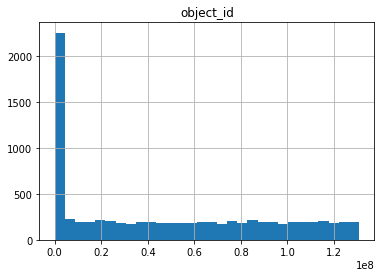

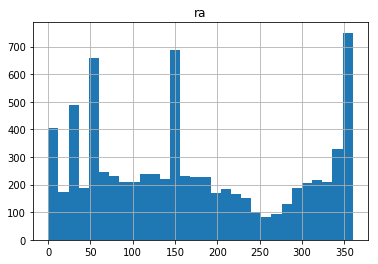

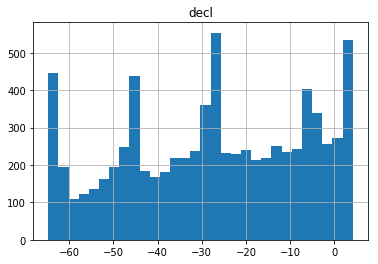

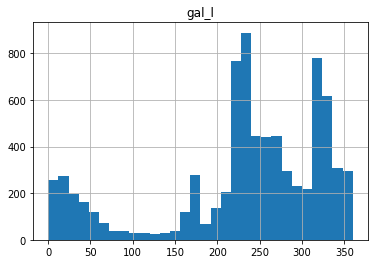

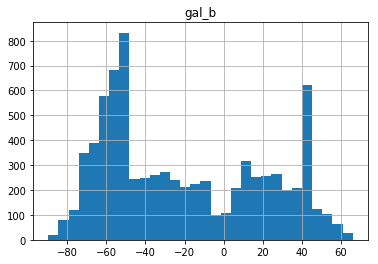

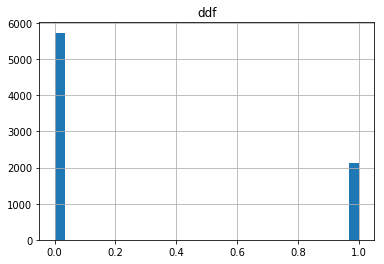

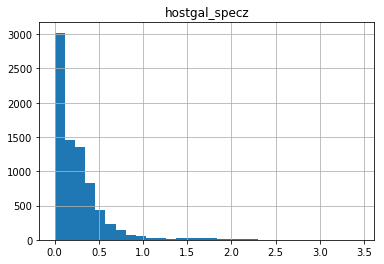

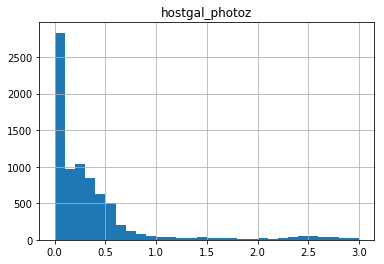

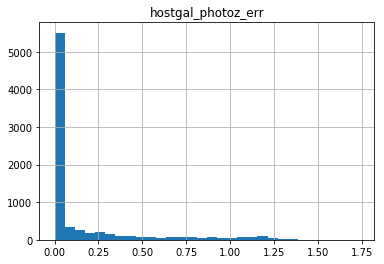

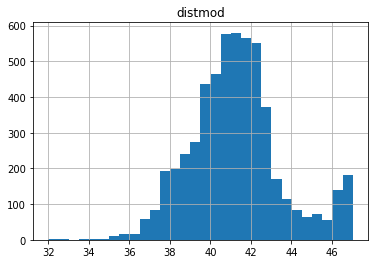

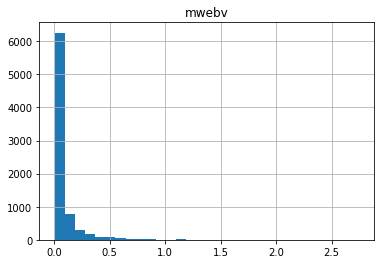

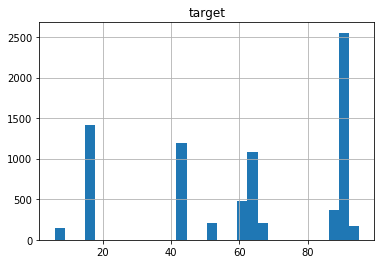

In [12]:
for c in train.columns:
    train[c].hist(bins=30); plt.title(c); plt.show()

In [13]:
train2 = pd.read_csv('../input/training_set.csv.zip')

In [14]:
train2 = pd.merge(train2, train[['object_id', 'target']], on='object_id', how='left')

In [15]:
train2.groupby('target').flux.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
6,20830.0,739.980950,16882.122122,-7.586973e+04,-17.674960,1.554842,36.642159,6.142572e+05
15,64440.0,35.770492,283.347255,-3.676708e+03,-3.558580,1.978581,14.483469,1.371389e+04
16,147474.0,0.180772,1115.314072,-2.131230e+05,-13.740500,2.313166,30.490550,1.723112e+05
42,212447.0,32.741144,515.962976,-2.893435e+02,-1.512906,0.981231,8.545941,4.344411e+04
52,37480.0,16.489283,126.526826,-1.783385e+02,-1.194365,0.938989,6.392239,3.924052e+03
53,4391.0,-1422.462960,18088.793996,-1.269998e+05,-4835.708496,-38.781647,970.587037,1.350143e+05
62,87079.0,20.333665,159.805073,-3.277472e+02,-1.725219,0.709981,6.576575,1.085099e+04
64,13418.0,6.338462,133.901778,-2.185388e+02,-4.895282,0.197852,5.946362,9.694985e+03
65,185894.0,-3.751268,112.271931,-1.476489e+03,-5.358306,-0.438983,2.841231,1.788759e+04


In [16]:
train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [17]:
train2.head()

,object_id,mjd,passband,flux,flux_err,detected,target
0,615,59750.4229,2,-544.810303,3.622952,1,92
1,615,59750.4306,1,-816.434326,5.553370,1,92
2,615,59750.4383,3,-471.385529,3.801213,1,92
3,615,59750.4450,4,-388.984985,11.395031,1,92
4,615,59752.4070,2,-681.858887,4.041204,1,92
